In [1]:
import os 
import time
import copy

import torch 
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

import matplotlib.pyplot as plt
import numpy as np

using device cuda:0


In [2]:
path = !pwd
path = path[0]
print(path)
mdl_savefile = path+"/models/resnet56_cumultrain_parameters.pickle"
mdl_loadfile = mdl_savefile

/home/ola/Documents/DD2424project


### ResNet-56 https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py

In [3]:
def _weights_init(m):
    classname = m.__class__.__name__
    print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal(m.weight)
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

### Olas Functions 

In [4]:
def show_model(model):
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())
def make_oneh(labels):
    oneh_labels = np.zeros([labels.shape[0], 10])
    indexes = np.array([np.arange(0,labels.shape[0]), labels.numpy()])
    oneh_labels[tuple(indexes)] = 1.0
    return torch.tensor(oneh_labels).long()
def get_xent_acc(prediction, labels):
    predicted_labels = np.argmax(prediction.cpu().data.numpy(),1)
    (predicted_labels - labels.cpu().data.numpy())
    return sum((predicted_labels - labels.cpu().data.numpy()) == 0)/predicted_labels.shape[0]
def xent_softmax(prediction):
    pred = np.exp(prediction.cpu().data.numpy())
    divide = np.repeat(pred.sum(1).reshape(pred.shape[0],1), pred.shape[1],1)
    pred = np.divide(pred,divide)
    return pred 
def get_valacc(valacc, valloss):
    with torch.no_grad():
        f"""certain layers have different properties during evaluation e.g dropout. 
            therefor we use resnet.eval()"""
        resnet.eval()      
        for i, (valimgs, vallabels) in enumerate(valid_data_loader):
            if cuda_available: 
                valimgs   = valimgs.cuda()
                vallabels = vallabels.cuda()
            valprediction = resnet.forward(valimgs)    
            valloss = valloss + [loss_xent(valprediction, vallabels)]
            valacc = valacc + [get_xent_acc(valprediction, vallabels)]
            break
        f"""reset resnet for training with resnet.train()"""
        resnet.train()
    return valacc, valloss
def compare_parameters(net1, net2):
    f"""compare parameters of two models with the same architecture""" 
    net1_param, net2_param, diff = [], [], 0
    for param_tensor in net1.state_dict():
        net1_param = net1_param + [net1.state_dict()[param_tensor]]
        net2_param = net2_param + [net2.state_dict()[param_tensor]]
    for i in range(len(net1_param)):
        diff = diff + np.sum(net1_param[i].cpu().numpy() - net2_param[i].cpu().numpy())
    print(f"""difference in weights and biases is: {diff} between network1 and network2""")
def load_cifar10(batchsize):
    torchvision.datasets.CIFAR10(path,download=True)
    f"""adding transform ToTensor(); transforms PIL-images to tensor-format used by PyTorch""" 
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
    cifar10_train = torchvision.datasets.CIFAR10(path, train=True, transform=transform)
    cifar10_valid = torchvision.datasets.CIFAR10(path, train=False,transform=transform)
    dataloader_tr = torch.utils.data.DataLoader(cifar10_train,
                                              batch_size=batchsize,
                                              shuffle=True,
                                              num_workers=0,
                                              pin_memory=True)
    dataloader_vl = torch.utils.data.DataLoader(cifar10_valid,
                                              batch_size=batchsize,
                                              shuffle=True,
                                              num_workers=0,
                                              pin_memory=True)
    return dataloader_tr, dataloader_vl
def range_test(net,opt,dataloader,lossfn,max_lr,min_lr,iterations,batchsize):
    scheduler = torch.optim.lr_scheduler.CyclicLR(opt, min_lr, max_lr, 
                                                  step_size_up=iterations, step_size_down=0, 
                                                  mode='triangular', cycle_momentum=False)
    start    = time.time()
    time_int = 100
    
    accuracy  = []
    loss      = []
    datait    = iter(dataloader)
    n_batches = len(datait)
    interval  = 5
    batch     = 0
    for i in range(1,iterations):
        batch += 1
        if batch >= n_batches:
            datait = iter(dataloader)
            batch = 0 
        images, labels = datait.next() 
        if cuda_available:
            images, labels = images.cuda(), labels.cuda()
        prediction = net.forward(images)
        output     = lossfn(prediction, labels)
        f"""Use accuracy on training-set"""
        if i % interval == 0:
            accuracy   = accuracy + [get_xent_acc(prediction, labels)]
            loss       = loss + [output]
        opt.zero_grad()   # clear gradients from previous time-step 
        output.backward() # calculates gradients 
        opt.step()        # updates weights
        scheduler.step()  # change learning-rate in range_optimizer
        if i % time_int == 0:
            print(f"""time after {i} iterations: {time.time() - start} seconds and accuracy is {accuracy[-1]}""")
            
    f"""make and save plot of accuracy"""
    x1, x2 = [np.linspace(min_lr, max_lr, num) for num in [len(accuracy), len(loss)]]
    plt.plot(x1, np.array(accuracy))
    save_file = path+f"""/rangetest/acc_bs{batchsize}_minlr{min_lr}_maxlr{max_lr}_iterations{iterations}_momentum{opt.param_groups[-1]['momentum']}_weightdecy{opt.param_groups[-1]['weight_decay']}.png"""
    plt.savefig(save_file)
    plt.show()
    return accuracy, loss

### learning-rate range-test

In [11]:
%%capture
network = ResNet(BasicBlock,[9,9,9])
if cuda_available: network.cuda()

Files already downloaded and verified
time after 100 iterations: 8.812482118606567 seconds and accuracy is 0.10546875
time after 200 iterations: 17.64452600479126 seconds and accuracy is 0.3046875
time after 300 iterations: 26.491397380828857 seconds and accuracy is 0.37890625
time after 400 iterations: 35.32120990753174 seconds and accuracy is 0.359375
time after 500 iterations: 44.194820404052734 seconds and accuracy is 0.4140625
time after 600 iterations: 53.05365824699402 seconds and accuracy is 0.4609375
time after 700 iterations: 61.96135067939758 seconds and accuracy is 0.41796875
time after 800 iterations: 70.86218237876892 seconds and accuracy is 0.5
time after 900 iterations: 79.78541040420532 seconds and accuracy is 0.5234375
time after 1000 iterations: 88.72312045097351 seconds and accuracy is 0.62890625
time after 1100 iterations: 97.70332646369934 seconds and accuracy is 0.5546875
time after 1200 iterations: 106.65901160240173 seconds and accuracy is 0.62890625
time after

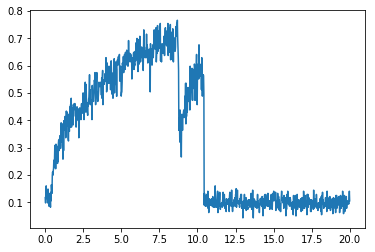

In [12]:
max_lr = 2e1
min_lr = 1e-9
iterations = 5000
lossfn = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=min_lr, 
                      momentum=0.95, weight_decay=1e-6)
for batchsize in [256]:
    dataloader_tr, dataloader_vl = load_cifar10(batchsize)
    accuracy, loss = range_test(network,optimizer,dataloader_tr,lossfn,max_lr,min_lr,iterations,batchsize)

In [36]:
what = np.linspace(1e-9, 1e-1, 1000)
print(what[0:10])
whej = []
f = (1e-1 - 1e-9)/1000
for i in range(1000):
    whej = whej + [i*f]
print(whej[0:10])

plt.plot()

[1.00000000e-09 1.00101099e-04 2.00201198e-04 3.00301297e-04
 4.00401396e-04 5.00501495e-04 6.00601595e-04 7.00701694e-04
 8.00801793e-04 9.00901892e-04]
[0.0, 9.999999900000001e-05, 0.00019999999800000002, 0.00029999999700000004, 0.00039999999600000004, 0.000499999995, 0.0005999999940000001, 0.000699999993, 0.0007999999920000001, 0.0008999999910000001]


1e-09


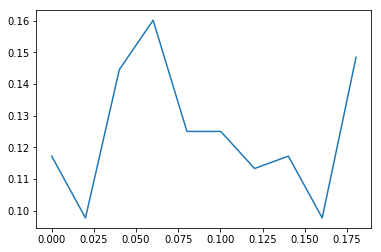

In [37]:
x1, x2 = [np.linspace(min_lr, max_lr, num) for num in [len(accuracy), len(loss)]]
print(x1[0])
np.linspace
plt.plot(x1[0:10], np.array(accuracy[0:10]))

### load-data

In [ ]:
batchsize = 128
dataloader_tr, dataloader_vl = load_cifar10(batchsize)

### network 

In [ ]:
%%capture
f"""To get ResNet56 use ResNet(BasicBlock,[9,9,9])""" 
resnet56 = ResNet(BasicBlock,[9,9,9])
if cuda_available: resnet56.cuda()

### loss-function    https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7

In [ ]:
loss_xent = nn.CrossEntropyLoss()

### optimize-function https://pytorch.org/docs/stable/optim.html

In [ ]:
optimizer = optim.SGD(resnet56.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# play with forward and backwards pass

In [ ]:
start    = time.time()
f"""load previous model"""
# if os.path.isfile(load_filename):
#     resnet.load_state_dict(torch.load(load_filename))
n_epoch  = 1
validation_interval = 10

trainacc  = [] 
valacc    = [] 
trainloss = []
valloss   = [] 

for epoch in range(n_epoch):
    train_iterator = iter(train_data_loader)
    for i in range(len(train_iterator)):
        images, labels = train_iterator.next()
        
        f"""if we use GPU, input- and target-tensors must be loaded on GPU as well."""
        if cuda_available: images, labels = images.cuda(), labels.cuda()
            
        prediction = resnet.forward(images)
        output     = loss_xent(prediction, labels)
        
        trainacc = trainacc + [get_xent_acc(prediction, labels)]
        trainloss = trainloss + [output]
        
        f"""using zero_grad() seems to be necessary. step() does not clear the gradients"""
        optimizer.zero_grad()
        output.backward() # calculates gradients 
        optimizer.step()  # updates weights
        
        if i % validation_interval == 0:
            valacc, valloss = get_valacc(valacc, valloss)
            
    print(f"""time passed after training {epoch+1} epochs is {time.time()-start} seconds""")

### Plot results 

In [ ]:
x1, x2, x3 = [np.linspace(0, len(trainacc), num) for num in [len(trainloss), len(trainacc), len(valacc)]]

In [ ]:
plt.plot(x1,np.array(trainloss))
plt.show()

In [ ]:
plt.plot(x2,np.array(trainacc))
plt.plot(x3,np.array(valacc))
plt.show()

### Save/Load Model
### https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [ ]:
%%capture 
f"""save"""
torch.save(resnet.state_dict(), save_filename)
f"""load"""
resnet2 = ResNet(BasicBlock,[9,9,9])
resnet2.load_state_dict(torch.load(load_filename))
compare_parameters(resnet,resnet2)

#### DenseNet

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
imshow(torchvision.utils.make_grid(images.cpu()))

In [ ]:
densenet = models.densenet161()